In [1]:
import glob
import sys,os
import geopandas as gpd
import numpy as np
from tkinter import filedialog,messagebox
import tkinter as tk
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Optional, Tuple

In [2]:
## output folder path
output_dir = "D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4"
os.makedirs(output_dir, exist_ok=True)

## dwg file and ODA convertor
input_folder_dwg_file = "D:/2_Analytics/6_plan_vs_actual/raw_data_dwg_file/dwg_file"
oda_exe = "C:/Program Files/ODA/ODAFileConverter 26.7.0/ODAFileConverter.exe"
section_line_folder = os.path.join(output_dir, "section_lines")
os.makedirs(section_line_folder, exist_ok=True)

## Dtms
dtm_itr1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
dtm_itr1_year_ip =  2024                              
dtm_itr1_year_ip = dtm_itr1_year_ip if dtm_itr1_year_ip else "itr1"

dtm_itr2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_2.tif"
dtm_itr2_year_ip = 2025                              
dtm_itr2_year_ip = dtm_itr2_year_ip if dtm_itr2_year_ip else "itr2"

## section line path
section_line_path = "D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/section_lines/LINES_with_start_end_text.shp"

## new output folder to save outputs
new_sectional_output = "D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new"


section_number = 1


Fetch the output from linear deviation

In [3]:
def get_linear_outputs(output_dir):
    shape_folder = os.path.join(output_dir, "shape_file_outputs")

    base_names = [
        "planned_and_done_excavation",
        "unplanned_and_done_excavation",
        "planned_and_done_dump",
        "unplanned_and_done_dump",
    ]
    results = []
    for base in base_names:
        pattern = os.path.join(shape_folder, f"{base}.shp")  # only .shp
        matches = glob.glob(pattern)
        results.append(matches[0] if matches else None)

    return tuple(results)

(done_exv, unplanned_exv, done_dump, unplanned_dump) = get_linear_outputs(output_dir)
print(done_exv)
print(unplanned_exv)
print(done_dump)
print(unplanned_dump)


D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4\shape_file_outputs\planned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4\shape_file_outputs\unplanned_and_done_excavation.shp
None
D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4\shape_file_outputs\unplanned_and_done_dump.shp


Read the section line and fetch the elevations from both dtms

In [4]:
# --- step 1: helper (you already have this) ---
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from an already opened DTM raster at (x, y)."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# --- step 2: main combined sampler ---
def sample_elevations_two_dtms(
    dtm_path1: str,
    dtm_path2: str,
    section_gdf: gpd.GeoDataFrame,
    interval: float = 0.01
) -> pd.DataFrame:
    """
    Interpolates points along the *first* feature in section_gdf,
    fetches elevations from both DTMs, and returns a DataFrame.

    Columns: ['chainage','x','y','z_itr1','z_itr2']
    """
    # Ensure we only take first feature as GeoDataFrame
    line_gdf = section_gdf.iloc[[section_number]]

    # Get the LineString geometry
    geom = line_gdf.geometry.iloc[0]
    if not isinstance(geom, LineString):
        raise ValueError("First feature is not a LineString!")

    length = geom.length
    num_points = int(length // interval) + 1
    distances = [i * interval for i in range(num_points + 1)]
    if distances[-1] < length:  # make sure last point is included
        distances.append(length)

    rows = []
    with rasterio.open(dtm_path1) as dtm1, rasterio.open(dtm_path2) as dtm2:
        # Reproject line_gdf if needed
        if line_gdf.crs is not None:
            if line_gdf.crs != dtm1.crs:
                print("Reprojecting section line to match DTM CRS...")
                line_gdf = line_gdf.to_crs(dtm1.crs)
                geom = line_gdf.geometry.iloc[0]

        for d in distances:
            pt = geom.interpolate(d)
            x, y = pt.x, pt.y
            z1 = elevation_at_point(dtm1, x, y)
            z2 = elevation_at_point(dtm2, x, y)
            rows.append((d, x, y, z1, z2))

    df = pd.DataFrame(rows, columns=["chainage", "x", "y", "z_itr1", "z_itr2"])
    return df

section_gdf = gpd.read_file(section_line_path)


df = sample_elevations_two_dtms(
    dtm_path1=dtm_itr1_path,
    dtm_path2=dtm_itr2_path,
    section_gdf=section_gdf,
    interval=0.01
)

Compute the intersetion lines from linear deviation analysis 

In [15]:
def intersect_line_with_polygons_return_separately(line_gdf, 
                                                   output_folder_path: str,
                                                   planned_and_done_excavation_path: str = None,
                                                   unplanned_and_done_excavation_path: str = None,
                                                   planned_and_used_dump_path: str = None,
                                                   unplanned_and_used_dump_path: str = None):
    def process(name, poly_path):
        output_path = os.path.join(output_folder_path, f"section_{section_name}_{name}.shp")

        # Return empty GeoDataFrame if path is None or file does not exist
        if poly_path is None or not os.path.exists(poly_path):
            print(f"{name}: File path is None or does not exist.")
            empty_gdf = gpd.GeoDataFrame(geometry=[], crs=line_gdf.crs)
            empty_gdf.to_file(output_path)
            return empty_gdf

        poly_gdf = gpd.read_file(poly_path)
        if poly_gdf.empty:
            print(f"{name}: Polygon file is empty.")
            empty_gdf = gpd.GeoDataFrame(geometry=[], crs=line_gdf.crs)
            empty_gdf.to_file(output_path)
            return empty_gdf

        # Reproject to match CRS
        if poly_gdf.crs != line_gdf.crs:
            poly_gdf = poly_gdf.to_crs(line_gdf.crs)

        poly_union = poly_gdf.union_all()
        intersection = line_geom.intersection(poly_union)

        segments = []
        if intersection.is_empty:
            print(f"{name}: No intersection.")
        elif isinstance(intersection, LineString):
            segments.append(intersection)
        elif isinstance(intersection, MultiLineString):
            segments.extend(intersection.geoms)
        else:
            print(f"{name}: Unsupported geometry type {type(intersection)}")

        # Prepare GeoDataFrame
        intersect_gdf = gpd.GeoDataFrame(geometry=segments, crs=poly_gdf.crs)

        if not intersect_gdf.empty:
            intersect_gdf["temp_id"] = intersect_gdf.index
            intersect_gdf = gpd.sjoin(intersect_gdf, poly_gdf[["geometry", "AREA_NAME"]], how="left", predicate="intersects")
            intersect_gdf = intersect_gdf.drop(columns=["index_right", "temp_id"])

        # Save output
        intersect_gdf.to_file(output_path)
        return intersect_gdf

    # Ensure only one line feature is present
    if len(line_gdf) != 1:
        raise ValueError("Line GeoDataFrame must contain exactly one feature.")
    line_geom = line_gdf.geometry.iloc[0]

    row = line_gdf.iloc[0]                       # first row
    section_name = f"{row['start_text']}_{row['end_text']}"
    print(section_name)

    # Process each layer
    lines_planned_and_done_excavation = process("planned_and_done_excavation", planned_and_done_excavation_path)
    lines_unplanned_and_done_excavation = process("unplanned_and_done_excavation", unplanned_and_done_excavation_path)
    lines_planned_and_used_dump = process("planned_and_used_dump", planned_and_used_dump_path)
    lines_unplanned_and_used_dump = process("unplanned_and_used_dump", unplanned_and_used_dump_path)

    return (
        lines_planned_and_done_excavation,
        lines_unplanned_and_done_excavation,
        lines_planned_and_used_dump,
        lines_unplanned_and_used_dump
    ), section_name



(   lines_planned_and_done_excavation,
    lines_unplanned_and_done_excavation,
    lines_planned_and_used_dump,
    lines_unplanned_and_used_dump  ), section_name = intersect_line_with_polygons_return_separately(
                                                    line_gdf=section_gdf.iloc[[section_number]],
                                                    output_folder_path= new_sectional_output,
                                                    planned_and_done_excavation_path = done_exv,
                                                    unplanned_and_done_excavation_path = unplanned_exv,
                                                    planned_and_used_dump_path = done_dump,
                                                    unplanned_and_used_dump_path  = unplanned_dump)       

J_J'
planned_and_used_dump: File path is None or does not exist.


Fetch the elevations at intersected locations

In [6]:
def get_chainage_ranges(section_df: pd.DataFrame, line_gdf):
    """
    Compute start/end chainage numbers for each LineString in line_gdf.

    Parameters
    ----------
    section_df : pd.DataFrame
        Must contain ['chainage','x','y'] sampled along a section line.
    line_gdf : GeoDataFrame
        Must contain LineString geometries (sub-lines lying on section line).

    Returns
    -------
    pd.DataFrame with columns: ['feature_id','start_chainage','end_chainage']
    """
    # Reconstruct the section line from df points
    section_line = LineString(section_df[['x','y']].to_numpy())
    chainages = section_df['chainage'].to_numpy()

    results = []
    for idx, geom in line_gdf.iterrows():
        line = geom.geometry
        if not isinstance(line, LineString):
            continue  # skip non-LineStrings

        # Start & end points of the sub-line
        start_pt = Point(line.coords[0])
        end_pt = Point(line.coords[-1])

        # Project onto the section line
        start_chain_exact = section_line.project(start_pt)
        end_chain_exact = section_line.project(end_pt)

        # Snap to nearest chainages in df
        start_chain = chainages[np.argmin(np.abs(chainages - start_chain_exact))]
        end_chain = chainages[np.argmin(np.abs(chainages - end_chain_exact))]

        # Ensure start < end
        start_chain, end_chain = sorted([start_chain, end_chain])

        results.append((idx, start_chain, end_chain))

    return pd.DataFrame(results, columns=["feature_id","start_chainage","end_chainage"])


chainage_ranges = get_chainage_ranges(df, line_gdf= lines_planned_and_done_excavation)
print(chainage_ranges)

   feature_id  start_chainage  end_chainage
0           0         1511.32       1517.98


In [7]:
# def add_labels_for_planned_area(
#     section_df: pd.DataFrame,
#     line_gdf,
#     key: str,
#     output_csv: str = None
# ):
#     # Ensure required columns exist
#     if "line_name" not in section_df.columns:
#         section_df["line_name"] = np.nan
#     if "area_name" not in section_df.columns:
#         section_df["area_name"] = pd.Series([None] * len(section_df), dtype="object")

#     # Early exit if no line_gdf provided
#     if line_gdf is None:
#         print(f"Skipped: line_gdf is None for key '{key}'.")
#     elif line_gdf.empty:
#         print(f"Skipped: line_gdf has no features for key '{key}'.")
#     else:
#         if "AREA_NAME" not in line_gdf.columns:
#             raise ValueError("line_gdf must contain an 'AREA_NAME' column.")

#         # Build the full section line
#         section_line = LineString(section_df[['x','y']].to_numpy())
#         chainages = section_df['chainage'].to_numpy()

#         for idx, geom in line_gdf.iterrows():
#             line = geom.geometry
#             area_name = geom["AREA_NAME"] if "AREA_NAME" in geom else None

#             if not isinstance(line, LineString):
#                 continue  # skip non-LineString

#             # Start & end points
#             start_pt = Point(line.coords[0])
#             end_pt = Point(line.coords[-1])

#             # Project onto section line
#             start_chain_exact = section_line.project(start_pt)
#             end_chain_exact = section_line.project(end_pt)

#             # Snap to nearest sampled chainages
#             start_chain = chainages[np.argmin(np.abs(chainages - start_chain_exact))]
#             end_chain = chainages[np.argmin(np.abs(chainages - end_chain_exact))]

#             # Ensure start <= end
#             start_chain, end_chain = sorted([start_chain, end_chain])

#             # Mask rows in section_df within this range and set labels
#             mask = (section_df["chainage"] >= start_chain) & (section_df["chainage"] <= end_chain)
#             section_df.loc[mask, "line_name"] = key
#             section_df.loc[mask, "area_name"] = area_name

#     # Save to CSV if requested
#     if output_csv:
#         section_df.to_csv(output_csv, index=False)
#         print(f"Updated DataFrame exported to: {output_csv}")

#     return section_df




# def add_labels_for_unplanned_area(
#     section_df: pd.DataFrame,
#     line_gdf,
#     key: str,
#     threshold: float,
#     output_csv: str = None
# ):
#     # Ensure required elevation columns exist
#     required = {"chainage", "x", "y", "z_itr1", "z_itr2"}
#     if not required.issubset(section_df.columns):
#         missing = required - set(section_df.columns)
#         raise ValueError(f"section_df missing required columns: {missing}")

#     # Ensure line_name and area_name columns exist
#     if "line_name" not in section_df.columns:
#         section_df["line_name"] = np.nan
#     if "area_name" not in section_df.columns:
#         section_df["area_name"] = pd.Series([None] * len(section_df), dtype="object")

#     # Early exit if no line_gdf provided
#     if line_gdf is None:
#         print(f"Skipped: line_gdf is None for key '{key}'.")
#     elif getattr(line_gdf, "empty", False):
#         # handles both None and empty GeoDataFrame
#         print(f"Skipped: line_gdf has no features for key '{key}'.")
#     else:
#         # If AREA_NAME not present, still proceed but area_name will be set to None
#         has_area_name = "AREA_NAME" in line_gdf.columns

#         # Build the full section line from the sampled coordinates
#         section_line = LineString(section_df[['x', 'y']].to_numpy())
#         chainages = section_df['chainage'].to_numpy()

#         for idx, row in line_gdf.iterrows():
#             line = row.geometry
#             if not isinstance(line, LineString):
#                 # skip non-LineString features
#                 continue

#             area_name = row["AREA_NAME"] if has_area_name else None

#             # Start & end points of the blue line
#             start_pt = Point(line.coords[0])
#             end_pt = Point(line.coords[-1])

#             # Project onto section line -> exact continuous chainage
#             start_chain_exact = section_line.project(start_pt)
#             end_chain_exact = section_line.project(end_pt)

#             # Snap to nearest sampled chainages in section_df
#             start_chain = chainages[np.argmin(np.abs(chainages - start_chain_exact))]
#             end_chain = chainages[np.argmin(np.abs(chainages - end_chain_exact))]

#             # Ensure start <= end
#             start_chain, end_chain = sorted([start_chain, end_chain])

#             # Mask rows in section_df within this range
#             mask = (section_df["chainage"] >= start_chain) & (section_df["chainage"] <= end_chain)

#             # Compute absolute diffs for this range
#             diffs = (section_df.loc[mask, "z_itr1"] - section_df.loc[mask, "z_itr2"]).abs()

#             if (diffs > threshold).any():
#                 # Keep the label and set area_name
#                 section_df.loc[mask, "line_name"] = key
#                 section_df.loc[mask, "area_name"] = area_name
#             else:
#                 # Remove any label/area_name for this range (no significant difference)
#                 section_df.loc[mask, "line_name"] = np.nan
#                 section_df.loc[mask, "area_name"] = np.nan
#                 print(f"Removed label for '{key}' at feature {idx}: no elevation diff > {threshold}")

#     # Save to CSV if requested
#     if output_csv:
#         section_df.to_csv(output_csv, index=False)
#         print(f"Updated DataFrame exported to: {output_csv}")

#     return section_df

In [8]:
def add_labels_for_planned_area(
    section_df: pd.DataFrame,
    line_gdf,
    key: str,
    output_csv: str = None
):
    # Ensure required columns exist
    if "line_name" not in section_df.columns:
        section_df["line_name"] = np.nan
    if "area_name" not in section_df.columns:
        section_df["area_name"] = pd.Series([None] * len(section_df), dtype="object")
    # NEW: ensure label_name column exists
    if "label_name" not in section_df.columns:
        section_df["label_name"] = pd.Series([None] * len(section_df), dtype="object")

    # Early exit if no line_gdf provided
    if line_gdf is None:
        print(f"Skipped: line_gdf is None for key '{key}'.")
    elif line_gdf.empty:
        print(f"Skipped: line_gdf has no features for key '{key}'.")
    else:
        if "AREA_NAME" not in line_gdf.columns:
            raise ValueError("line_gdf must contain an 'AREA_NAME' column.")

        # Build the full section line
        section_line = LineString(section_df[['x','y']].to_numpy())
        chainages = section_df['chainage'].to_numpy()

        for idx, geom in line_gdf.iterrows():
            line = geom.geometry
            area_name = geom["AREA_NAME"] if "AREA_NAME" in geom else None

            if not isinstance(line, LineString):
                continue  # skip non-LineString

            # Start & end points
            start_pt = Point(line.coords[0])
            end_pt = Point(line.coords[-1])

            # Project onto section line
            start_chain_exact = section_line.project(start_pt)
            end_chain_exact = section_line.project(end_pt)

            # Snap to nearest sampled chainages
            start_chain = chainages[np.argmin(np.abs(chainages - start_chain_exact))]
            end_chain = chainages[np.argmin(np.abs(chainages - end_chain_exact))]

            # Ensure start <= end
            start_chain, end_chain = sorted([start_chain, end_chain])

            # Mask rows in section_df within this range and set labels
            mask = (section_df["chainage"] >= start_chain) & (section_df["chainage"] <= end_chain)
            section_df.loc[mask, "line_name"] = key
            section_df.loc[mask, "area_name"] = area_name

            # Derive label_name from area_name (Excavation Area i / Dump Area i)
            label_value = None
            if isinstance(area_name, str):
                lower = area_name.lower()
                kind = None
                if "excavation" in lower:
                    kind = "Excavation Area"
                elif "dump" in lower:
                    kind = "Dump Area"

                # find the last integer in the string (e.g., area_23 -> 23)
                m = re.search(r'(\d+)(?!.*\d)', area_name)
                if kind and m:
                    label_value = f"{kind} {m.group(1)}"
                elif kind:
                    # if kind found but no number, use kind only
                    label_value = kind
                else:
                    # fallback: None (or you could set to area_name if you prefer)
                    label_value = None

            # apply label_value to the same mask rows
            section_df.loc[mask, "label_name"] = label_value

    # Save to CSV if requested
    if output_csv:
        section_df.to_csv(output_csv, index=False)
        print(f"Updated DataFrame exported to: {output_csv}")

    return section_df


import re
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point

def add_labels_for_unplanned_area(
    section_df: pd.DataFrame,
    line_gdf,
    key: str,
    threshold: float,
    output_csv: str = None
):
    """
    Label unplanned areas only if max abs(z_itr1 - z_itr2) in the area exceeds `threshold`.
    Also create/populate `label_name` like "Excavation Area <i>" or "Dump Area <i>" (case-sensitive).
    """

    # Ensure required elevation columns exist
    required = {"chainage", "x", "y", "z_itr1", "z_itr2"}
    if not required.issubset(section_df.columns):
        missing = required - set(section_df.columns)
        raise ValueError(f"section_df missing required columns: {missing}")

    # Ensure line_name, area_name, label_name columns exist
    if "line_name" not in section_df.columns:
        section_df["line_name"] = np.nan
    if "area_name" not in section_df.columns:
        section_df["area_name"] = pd.Series([None] * len(section_df), dtype="object")
    if "label_name" not in section_df.columns:
        section_df["label_name"] = pd.Series([None] * len(section_df), dtype="object")

    # Early exit if no line_gdf provided
    if line_gdf is None:
        print(f"Skipped: line_gdf is None for key '{key}'.")
    elif getattr(line_gdf, "empty", False):
        print(f"Skipped: line_gdf has no features for key '{key}'.")
    else:
        has_area_name = "AREA_NAME" in line_gdf.columns

        # Build the full section line from the sampled coordinates
        section_line = LineString(section_df[['x', 'y']].to_numpy())
        chainages = section_df['chainage'].to_numpy()

        # helper to derive clean label_name from raw area_name
        def derive_label(area_name: str) -> str:
            if not isinstance(area_name, str):
                return None
            lower = area_name.lower()
            kind = None
            if "excavation" in lower:
                kind = "Excavation Area"
            elif "dump" in lower:
                kind = "Dump Area"
            # find the last integer in the string (if any)
            m = re.search(r'(\d+)(?!.*\d)', area_name)
            if kind and m:
                return f"{kind} {m.group(1)}"
            elif kind:
                return kind
            return None

        for idx, row in line_gdf.iterrows():
            line = row.geometry
            if not isinstance(line, LineString):
                # skip non-LineString features
                continue

            area_name = row["AREA_NAME"] if has_area_name else None

            # Start & end points of the blue line
            start_pt = Point(line.coords[0])
            end_pt = Point(line.coords[-1])

            # Project onto section line -> exact continuous chainage
            start_chain_exact = section_line.project(start_pt)
            end_chain_exact = section_line.project(end_pt)

            # Snap to nearest sampled chainages in section_df
            start_chain = chainages[np.argmin(np.abs(chainages - start_chain_exact))]
            end_chain = chainages[np.argmin(np.abs(chainages - end_chain_exact))]

            # Ensure start <= end
            start_chain, end_chain = sorted([start_chain, end_chain])

            # Mask rows in section_df within this range
            mask = (section_df["chainage"] >= start_chain) & (section_df["chainage"] <= end_chain)

            # Compute absolute diffs for this range
            diffs = (section_df.loc[mask, "z_itr1"] - section_df.loc[mask, "z_itr2"]).abs()

            if (diffs > threshold).any():
                # Significant deviation: keep the label and set area_name & label_name
                section_df.loc[mask, "line_name"] = key
                section_df.loc[mask, "area_name"] = area_name
                section_df.loc[mask, "label_name"] = derive_label(area_name)
            else:
                # No significant deviation: clear any label/area_name/label_name for this range
                section_df.loc[mask, "line_name"] = np.nan
                section_df.loc[mask, "area_name"] = np.nan
                section_df.loc[mask, "label_name"] = np.nan
                print(f"Removed label for '{key}' at feature {idx}: no elevation diff > {threshold}")

    # Save to CSV if requested
    if output_csv:
        section_df.to_csv(output_csv, index=False)
        print(f"Updated DataFrame exported to: {output_csv}")

    return section_df


In [9]:
df_1 = add_labels_for_planned_area(
                                    df,
                                    line_gdf=lines_planned_and_done_excavation,  # can be None or empty too
                                    key="planned_and_done_excavation",
                                    output_csv="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv"
                                    )

df_2 = add_labels_for_planned_area(
                                    df_1,
                                    line_gdf=lines_planned_and_used_dump,  # can be None or empty too
                                    key="planned_and_used_dump",
                                    output_csv="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv"
                                    )


df_3 = add_labels_for_unplanned_area(
                                    section_df=df_2,
                                    line_gdf=lines_unplanned_and_done_excavation,
                                    key="unplanned_and_done_excavation",
                                    threshold=2,  # e.g. require at least 0.2 m elevation difference
                                    output_csv="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv"
)


df_4 = add_labels_for_unplanned_area(
                                    section_df=df_3,
                                    line_gdf=lines_unplanned_and_used_dump,
                                    key="unplanned_and_used_dump",
                                    threshold=2,  # e.g. require at least 0.2 m elevation difference
                                    output_csv="D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv"
                                    )



C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_25756\100876216.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'planned_and_done_excavation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  section_df.loc[mask, "line_name"] = key


Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv
Skipped: line_gdf has no features for key 'planned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv
Removed label for 'unplanned_and_done_excavation' at feature 1: no elevation diff > 2
Removed label for 'unplanned_and_done_excavation' at feature 3: no elevation diff > 2
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/section_with_labels.csv
Removed label for 'unplanned_and_used_dump' at feature 0: no elevation diff > 2
Removed label for 'unplanned_and_used_dump' at feature 1: no elevation diff > 2
Removed label for 'unplanned_and_used_dump' at feature 2: no elevation diff > 2
Removed label for 'unplanned_and_used_dump' at feature 3: no elevation diff > 2
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/8_sept_outputs_4/output_new/secti

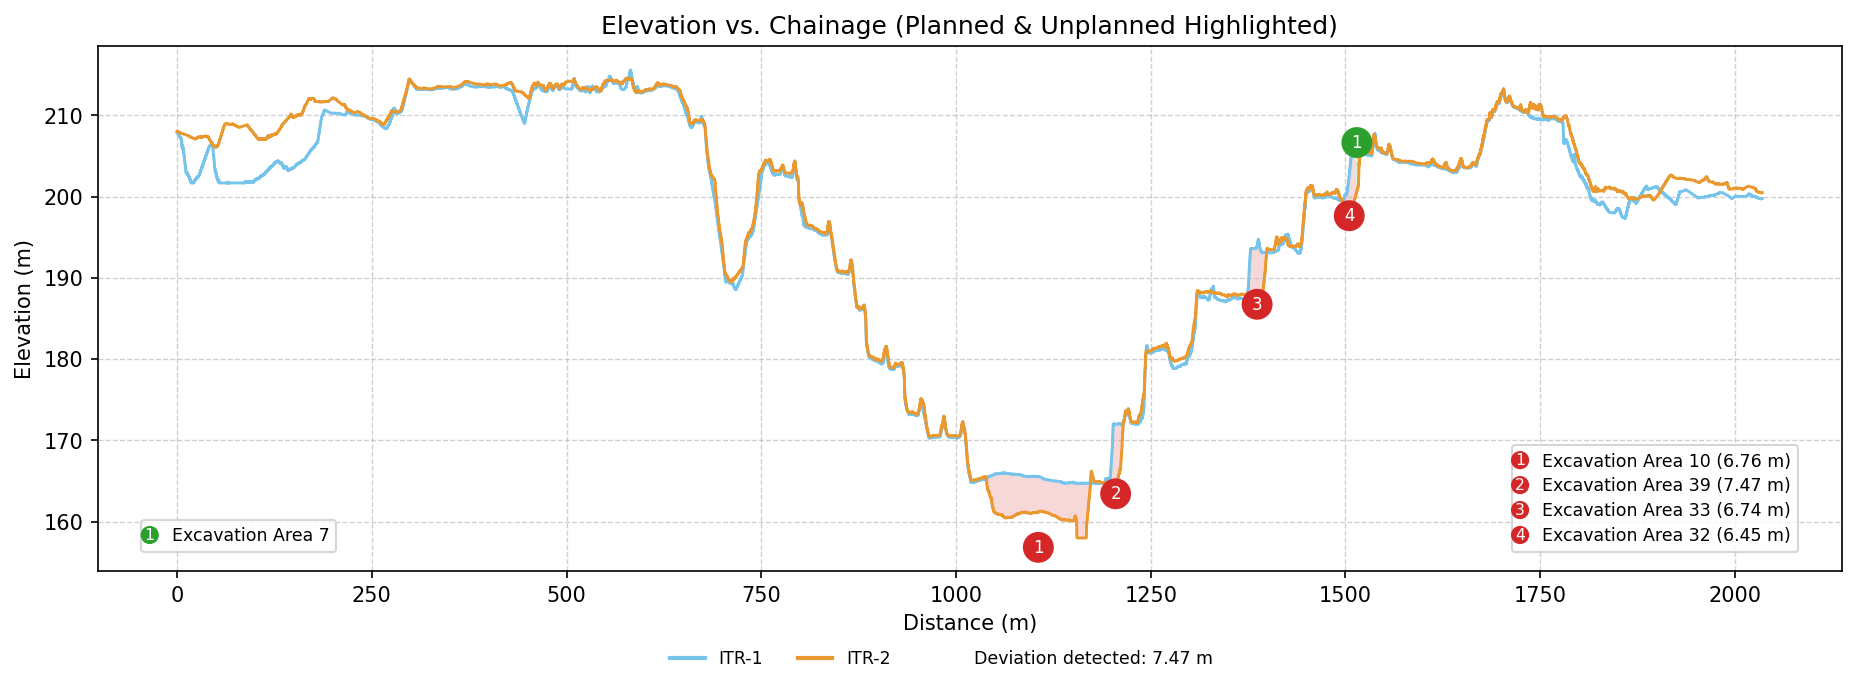

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (exact-match sets; change to substring detection if needed)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    # track max deviation among unplanned blocks
    max_unplanned_dev = 0.0
    has_unplanned = False

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        # prefer label_name if available, else fall back to area_name
        label_candidate = None
        if "label_name" in df_full.columns:
            label_candidate = df_full.loc[start_i, "label_name"]
        if pd.isna(label_candidate) or label_candidate is None:
            label_candidate = current_area

        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block — legend uses label_candidate
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)

            planned_labels.append(str(label_candidate) if label_candidate is not None else "")

            planned_num += 1
            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to legend label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))
            if deviation > max_unplanned_dev:
                max_unplanned_dev = deviation
            has_unplanned = True

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # use label_candidate and append deviation
            label_text = (str(label_candidate) if label_candidate is not None else "")
            unplanned_labels.append(f"{label_text} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # FIGURE-LEVEL LEGEND: ITR-1, ITR-2, and overall deviation status (in one row)
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    # invisible proxy handle for deviation text (keeps the text inline with the two line handles)
    proxy_dev = Line2D([], [], linestyle="", marker=None, color="none")
    if has_unplanned:
        dev_label = f"Deviation detected: {max_unplanned_dev:.2f} m"
    else:
        dev_label = "No deviation detected"

    # put the three labels on one legend row
    fig.legend(handles=[itr1_handle, itr2_handle, proxy_dev],
               labels=["ITR-1", "ITR-2", dev_label],
               loc="lower center", ncol=3, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax

plot_planned_and_unplanned_areas_with_numbered_legend(df_4)

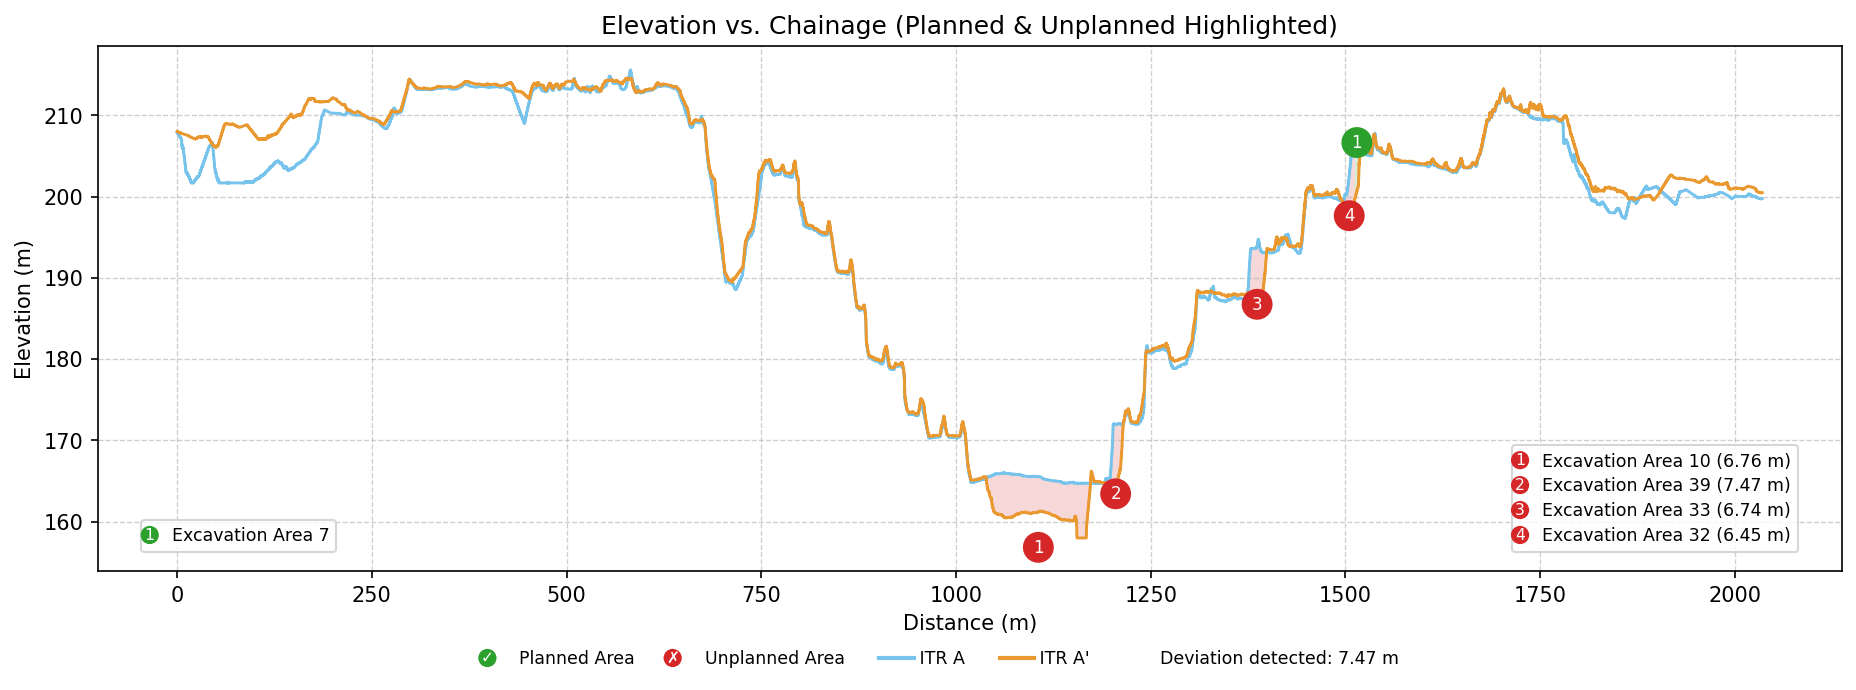

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


class SymbolCircleHandler(HandlerBase):
    """
    Legend handler for a colored circle with a fixed white symbol (e.g. ✓, ✗, !).
    """
    def __init__(self, symbol: str, fontsize_factor: float = 0.9, **kwargs):
        super().__init__(**kwargs)
        self.symbol = symbol
        self.fontsize_factor = fontsize_factor

    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        symbol_text = plt.Text(cx, cy, self.symbol,
                               transform=trans, color="white",
                               fontsize=fontsize * self.fontsize_factor, ha="center", va="center")
        return [circle, symbol_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    itr1 ,
    itr2 ,
    section_name,
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (exact-match sets; change to substring detection if needed)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    # track max deviation among unplanned blocks
    max_unplanned_dev = 0.0
    has_unplanned = False

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        # prefer label_name if available, else fall back to area_name
        label_candidate = None
        if "label_name" in df_full.columns:
            label_candidate = df_full.loc[start_i, "label_name"]
        if pd.isna(label_candidate) or label_candidate is None:
            label_candidate = current_area

        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block — legend uses label_candidate
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)

            planned_labels.append(str(label_candidate) if label_candidate is not None else "")

            planned_num += 1
            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to legend label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))
            if deviation > max_unplanned_dev:
                max_unplanned_dev = deviation
            has_unplanned = True

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # use label_candidate and append deviation
            label_text = (str(label_candidate) if label_candidate is not None else "")
            unplanned_labels.append(f"{label_text} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # --- Create side legends for numbered planned/unplanned areas as before ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # --- Combine ITR, deviation text, and Planned/Unplanned symbols into ONE single-line legend ---
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    proxy_dev = Line2D([], [], linestyle="", marker=None, color="none")

    dev_label = f"Deviation detected: {max_unplanned_dev:.2f} m" if has_unplanned else "No deviation detected"

    # --- Combined legend in desired order ---
    # planned/unplanned symbol proxies
    planned_symbol = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
    planned_symbol._size = legend_circle_size
    unplanned_symbol = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
    unplanned_symbol._size = legend_circle_size

    # ITR handles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)

    # deviation label
    proxy_dev = Line2D([], [], linestyle="", marker=None, color="none")
    dev_label = f"Deviation detected: {max_unplanned_dev:.2f} m" if has_unplanned else "No deviation detected"

    # order: Planned, Unplanned, ITR-1, ITR-2, deviation
    all_handles = [planned_symbol, unplanned_symbol, itr1_handle, itr2_handle, proxy_dev]
    all_labels  = ["Planned Area", "Unplanned Area", f" ITR {itr1}", f" ITR {itr2}", dev_label]

    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.03),   # adjust y-position
        ncol=len(all_handles),        # force single row
        frameon=False,
        fontsize="small",
        handler_map={
            planned_symbol: SymbolCircleHandler("✓"),
            unplanned_symbol: SymbolCircleHandler("✗")
        },
        handletextpad=0.005,
        
    )

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax



plot_planned_and_unplanned_areas_with_numbered_legend(df_4, itr1= "A", itr2 = "A'", section_name="A_A'")

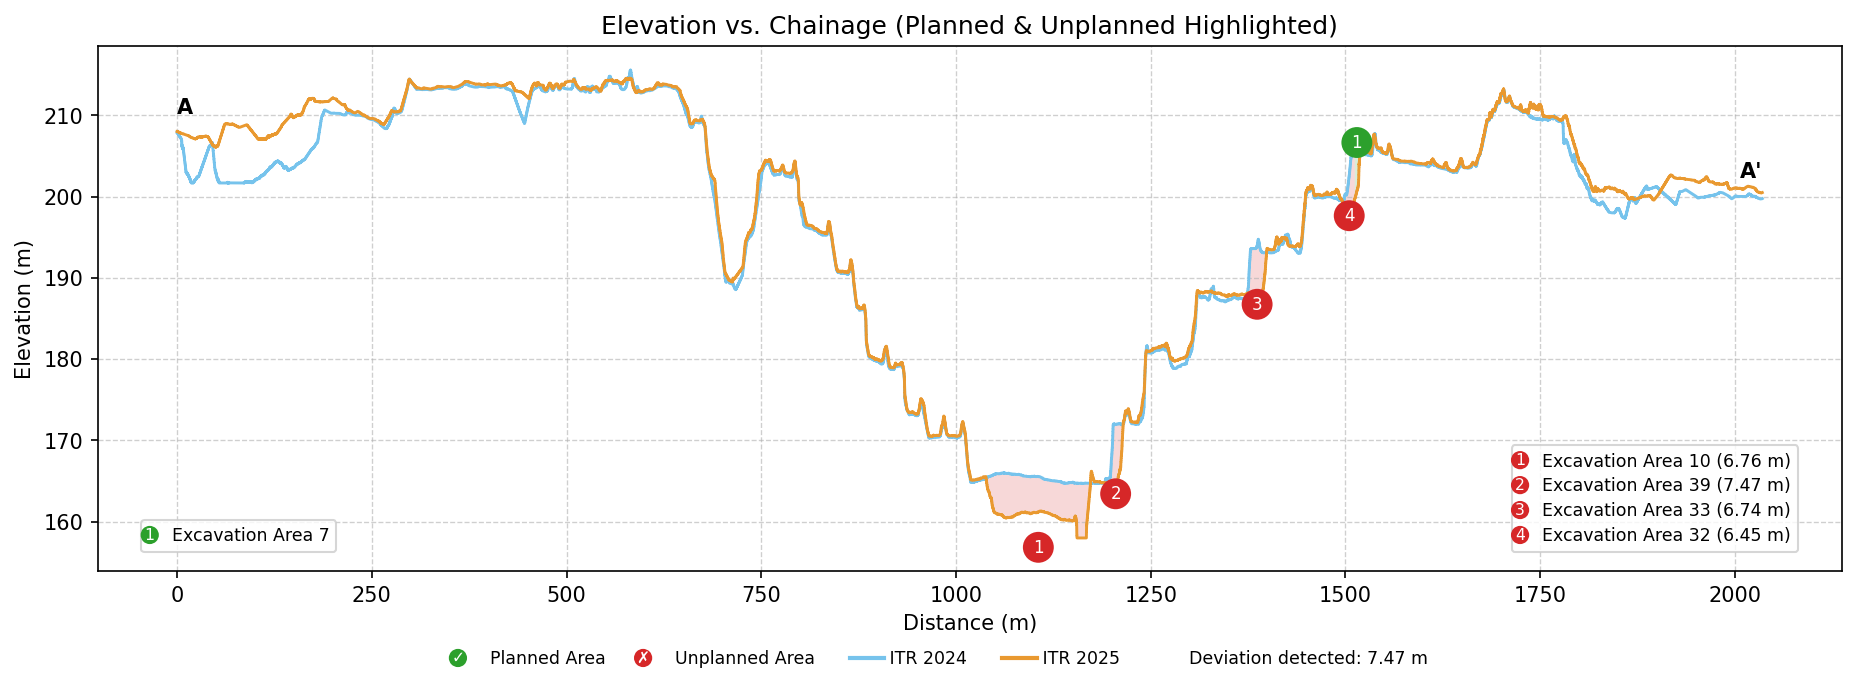

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple, Union

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


class SymbolCircleHandler(HandlerBase):
    """
    Legend handler for a colored circle with a fixed white symbol (e.g. ✓, ✗, !).
    """
    def __init__(self, symbol: str, fontsize_factor: float = 0.9, **kwargs):
        super().__init__(**kwargs)
        self.symbol = symbol
        self.fontsize_factor = fontsize_factor

    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        symbol_text = plt.Text(cx, cy, self.symbol,
                               transform=trans, color="white",
                               fontsize=fontsize * self.fontsize_factor, ha="center", va="center")
        return [circle, symbol_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    itr1: Union[str, int] = "1",        # used for legend label (e.g. "A")
    itr2: Union[str, int] = "2",        # used for legend label (e.g. "A'")
    section_name: str = "",             # e.g. "A_A'" -> placed as endpoint labels
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
    legend_columnspacing: float = 0.6,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plots elevation profiles (using columns 'z_itr1' and 'z_itr2') and highlights
    planned/unplanned blocks. `itr1` and `itr2` are used for label text in the legend.
    If section_name contains an underscore (e.g. "A_A'"), the two parts are placed
    near the left and right endpoints of the plotted profile.
    """

    # REQUIREMENT CHECK (unchanged from your original code)
    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    # Prepare dataframe (sort + optional downsample)
    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles (plot actual columns z_itr1 and z_itr2)
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label=f"ITR-{itr1}")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label=f"ITR-{itr2}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (exact-match sets)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for side legends (numbered circles)
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    # track max deviation among unplanned blocks
    max_unplanned_dev = 0.0
    has_unplanned = False

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        # prefer label_name if available, else fall back to area_name
        label_candidate = None
        if "label_name" in df_full.columns:
            label_candidate = df_full.loc[start_i, "label_name"]
        if pd.isna(label_candidate) or label_candidate is None:
            label_candidate = current_area

        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)

            planned_labels.append(str(label_candidate) if label_candidate is not None else "")

            planned_num += 1
            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block
        elif lbl in unplanned_set:
            deviation = float(np.max(np.abs(z1_block - z2_block)))
            if deviation > max_unplanned_dev:
                max_unplanned_dev = deviation
            has_unplanned = True

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            label_text = (str(label_candidate) if label_candidate is not None else "")
            unplanned_labels.append(f"{label_text} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # Side legends for numbered planned/unplanned areas
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Combine into one single-line legend in the requested order:
    # Planned, Unplanned, ITR-itr1, ITR-itr2, Deviation
    planned_symbol = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
    planned_symbol._size = legend_circle_size
    unplanned_symbol = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
    unplanned_symbol._size = legend_circle_size

    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    proxy_dev = Line2D([], [], linestyle="", marker=None, color="none")

    dev_label = f"Deviation detected: {max_unplanned_dev:.2f} m" if has_unplanned else "No deviation detected"

    all_handles = [planned_symbol, unplanned_symbol, itr1_handle, itr2_handle, proxy_dev]
    all_labels  = ["Planned Area", "Unplanned Area", f" ITR {itr1}", f" ITR {itr2}", dev_label]

    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.03),
        ncol=len(all_handles),
        frameon=False,
        fontsize="small",
        handler_map={
            planned_symbol: SymbolCircleHandler("✓"),
            unplanned_symbol: SymbolCircleHandler("✗")
        },
        handletextpad=0.0000005,
        #columnspacing=legend_columnspacing
    )

    # --- Add section endpoint labels if section_name contains an underscore like "A_A'" ---
    if section_name and "_" in section_name:
        left_label, right_label = section_name.split("_", 1)

        # endpoints from the plotted (possibly downsampled) dataframe
        x_start = float(df_plot["chainage"].iloc[0])
        x_end = float(df_plot["chainage"].iloc[-1])

        # take the z-values at endpoints (mean of the two series) so label sits near profile
        z_start_vals = np.array([df_plot["z_itr1"].iloc[0], df_plot["z_itr2"].iloc[0]])
        z_end_vals   = np.array([df_plot["z_itr1"].iloc[-1], df_plot["z_itr2"].iloc[-1]])
        y_start = np.nanmean(z_start_vals)
        y_end   = np.nanmean(z_end_vals)

        # offset labels slightly above the profile to avoid overlapping with markers
        offset = 0.03 * z_range
        ax.text(x_start, y_start + offset, left_label, ha="left", va="bottom",
                fontsize=10, fontweight="bold")
        ax.text(x_end,   y_end   + offset, right_label, ha="right", va="bottom",
                fontsize=10, fontweight="bold")

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax



plot_planned_and_unplanned_areas_with_numbered_legend(df_4, itr1="2024", itr2 = "2025", section_name="A_A'")

Plot the elevation profile 

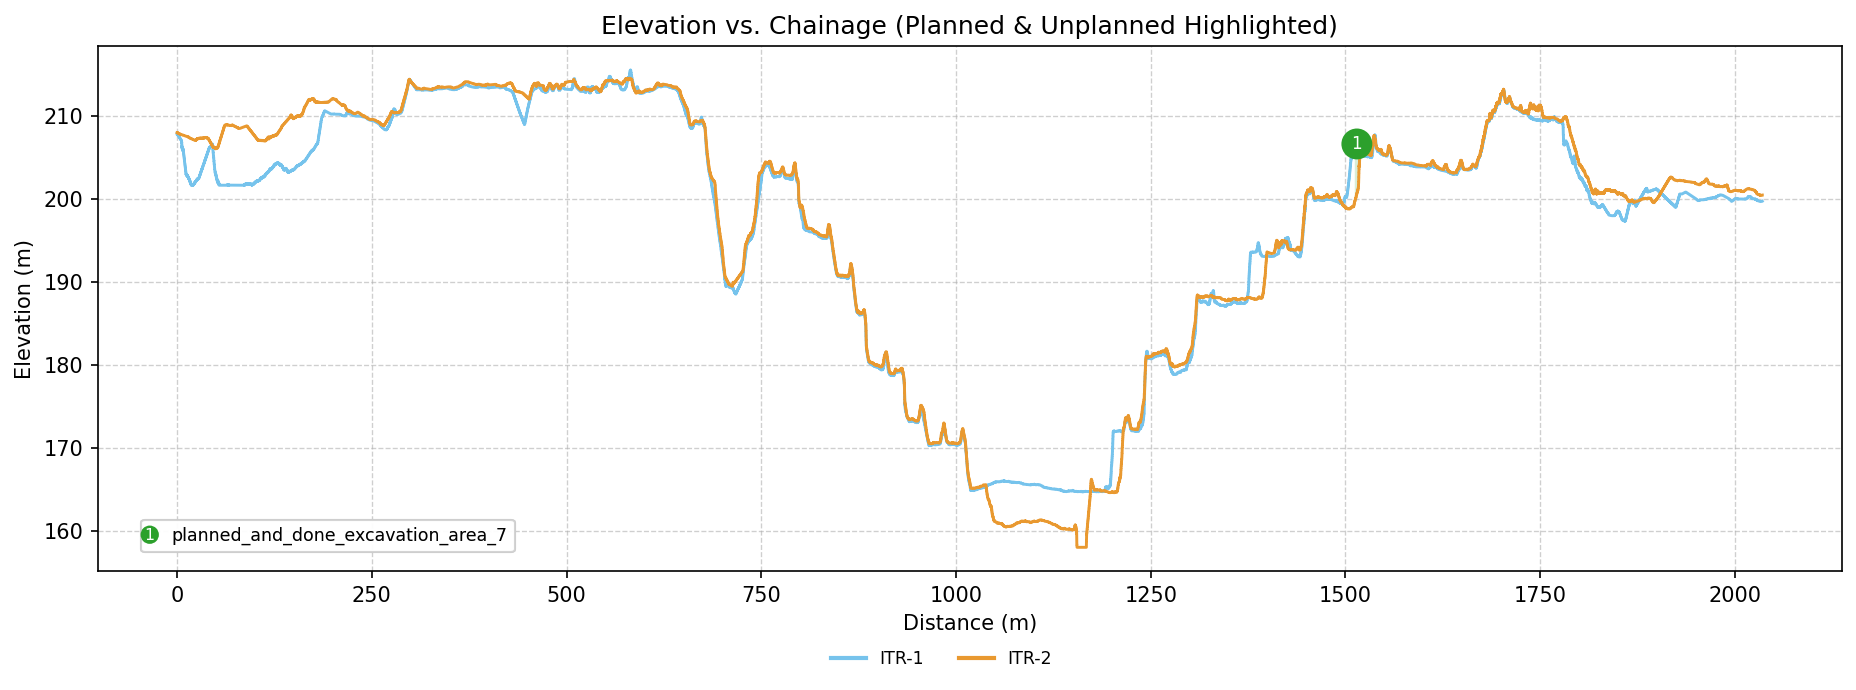

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (kept exact-match sets; adjust if your line_name varies)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)
            planned_labels.append(current_area)
            planned_num += 1

            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # attach deviation to the legend label (formatted to 2 decimals)
            unplanned_labels.append(f"{current_area} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # External legend for ITR profiles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


plot_planned_and_unplanned_areas_with_numbered_legend(df_4)

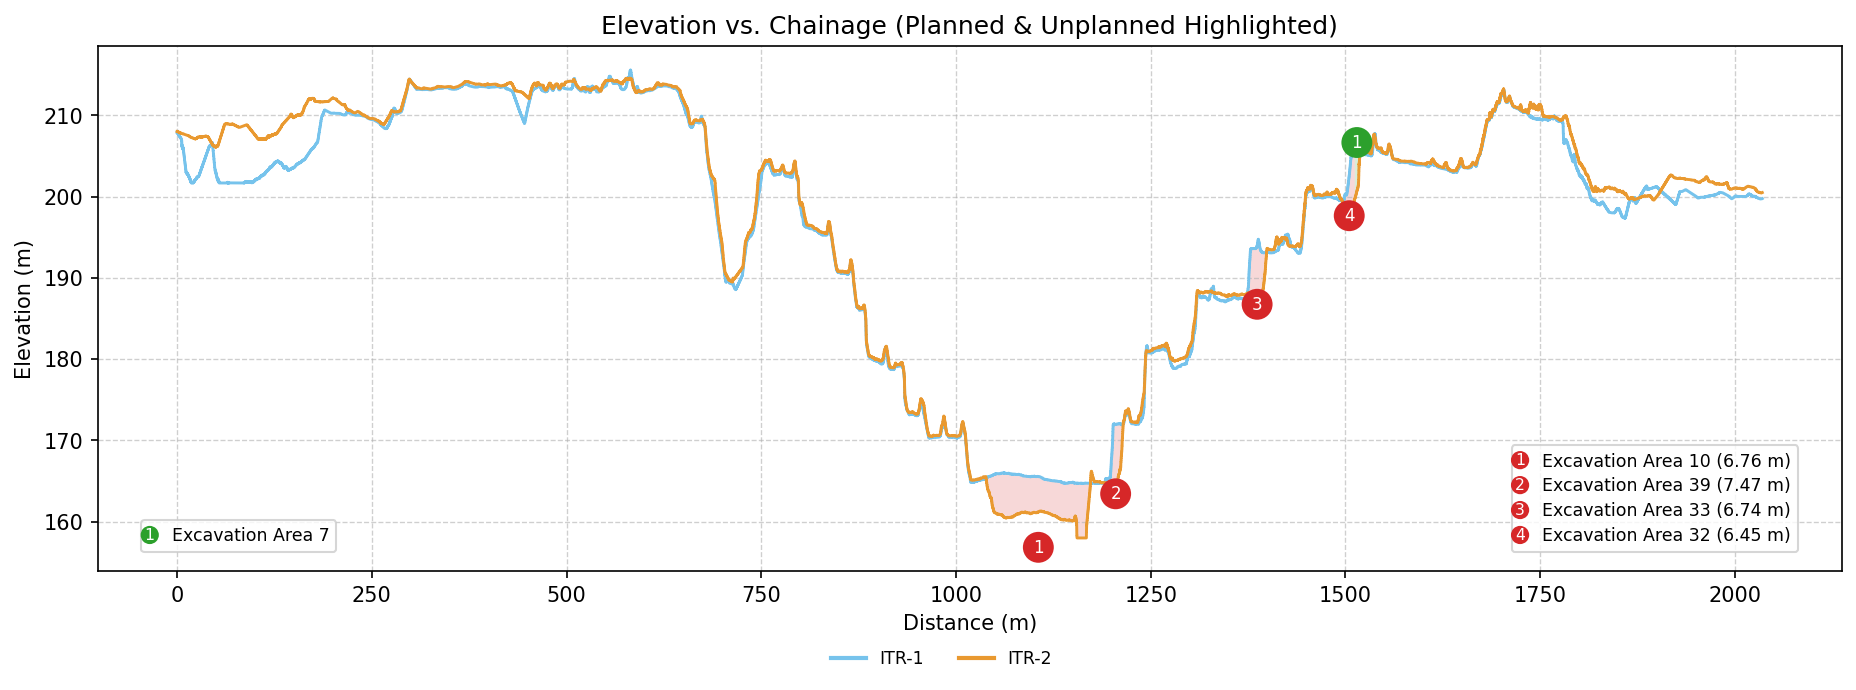

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (kept exact-match sets; adjust if your line_name varies)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        # prefer label_name if available, else fall back to area_name
        label_candidate = None
        if "label_name" in df_full.columns:
            label_candidate = df_full.loc[start_i, "label_name"]
        if pd.isna(label_candidate) or label_candidate is None:
            label_candidate = current_area

        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block — legend uses label_candidate
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)

            planned_labels.append(str(label_candidate) if label_candidate is not None else "")

            planned_num += 1
            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to legend label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # use label_candidate and append deviation
            label_text = (str(label_candidate) if label_candidate is not None else "")
            unplanned_labels.append(f"{label_text} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # External legend for ITR profiles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax

plot_planned_and_unplanned_areas_with_numbered_legend(df_4, itr_i=2024, itr_j=2025)

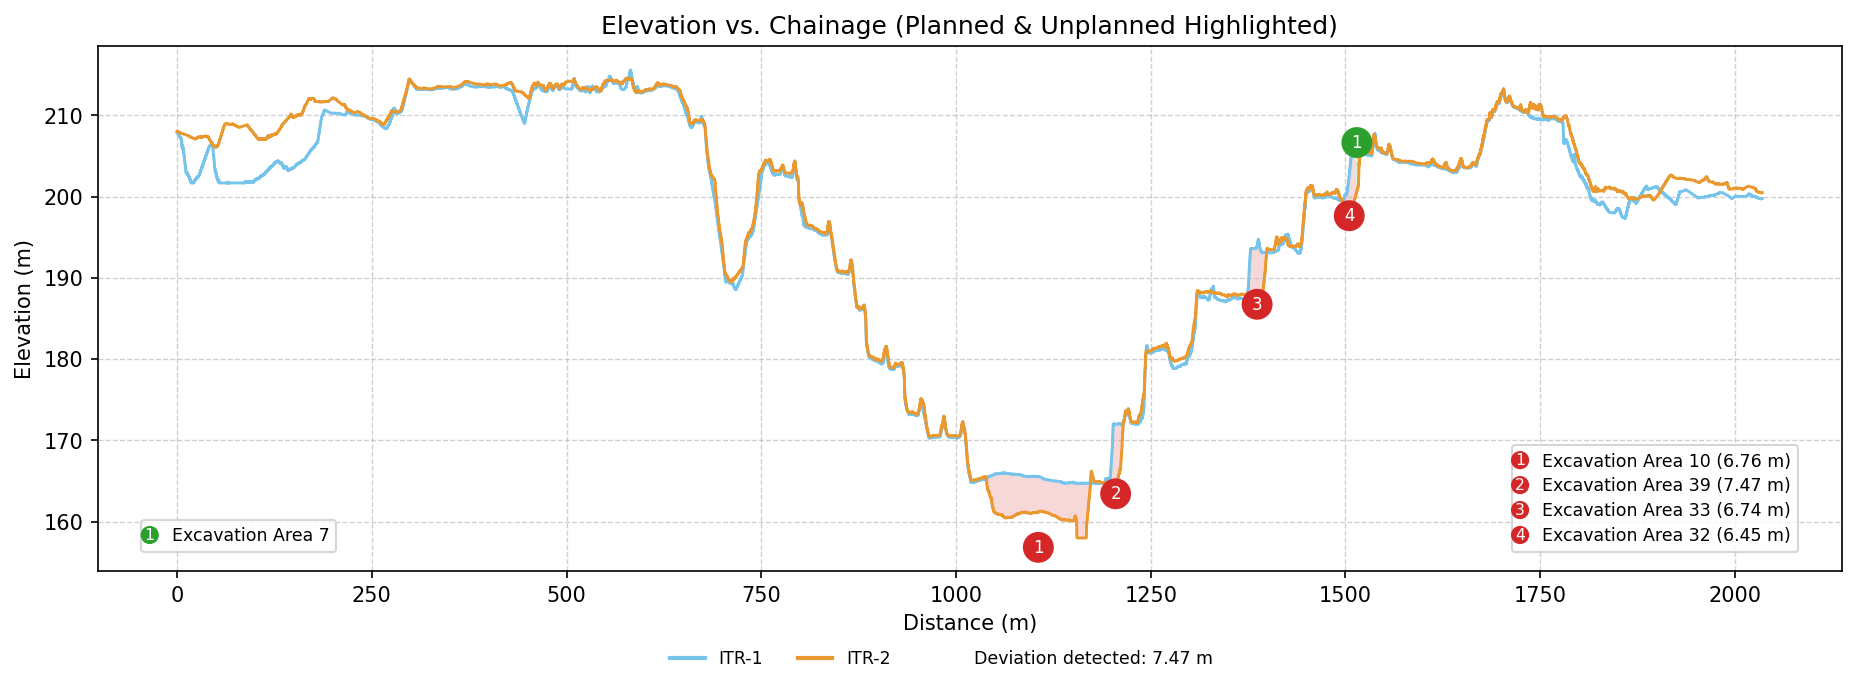

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.75,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (exact-match sets; change to substring detection if needed)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    # track max deviation among unplanned blocks
    max_unplanned_dev = 0.0
    has_unplanned = False

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        # prefer label_name if available, else fall back to area_name
        label_candidate = None
        if "label_name" in df_full.columns:
            label_candidate = df_full.loc[start_i, "label_name"]
        if pd.isna(label_candidate) or label_candidate is None:
            label_candidate = current_area

        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block — legend uses label_candidate
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)

            planned_labels.append(str(label_candidate) if label_candidate is not None else "")

            planned_num += 1
            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to legend label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))
            if deviation > max_unplanned_dev:
                max_unplanned_dev = deviation
            has_unplanned = True

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # use label_candidate and append deviation
            label_text = (str(label_candidate) if label_candidate is not None else "")
            unplanned_labels.append(f"{label_text} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # FIGURE-LEVEL LEGEND: ITR-1, ITR-2, and overall deviation status (in one row)
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    # invisible proxy handle for deviation text (keeps the text inline with the two line handles)
    proxy_dev = Line2D([], [], linestyle="", marker=None, color="none")
    if has_unplanned:
        dev_label = f"Deviation detected: {max_unplanned_dev:.2f} m"
    else:
        dev_label = "No deviation detected"

    # put the three labels on one legend row
    fig.legend(handles=[itr1_handle, itr2_handle, proxy_dev],
               labels=["ITR-1", "ITR-2", dev_label],
               loc="lower center", ncol=3, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax

plot_planned_and_unplanned_areas_with_numbered_legend(df_4)

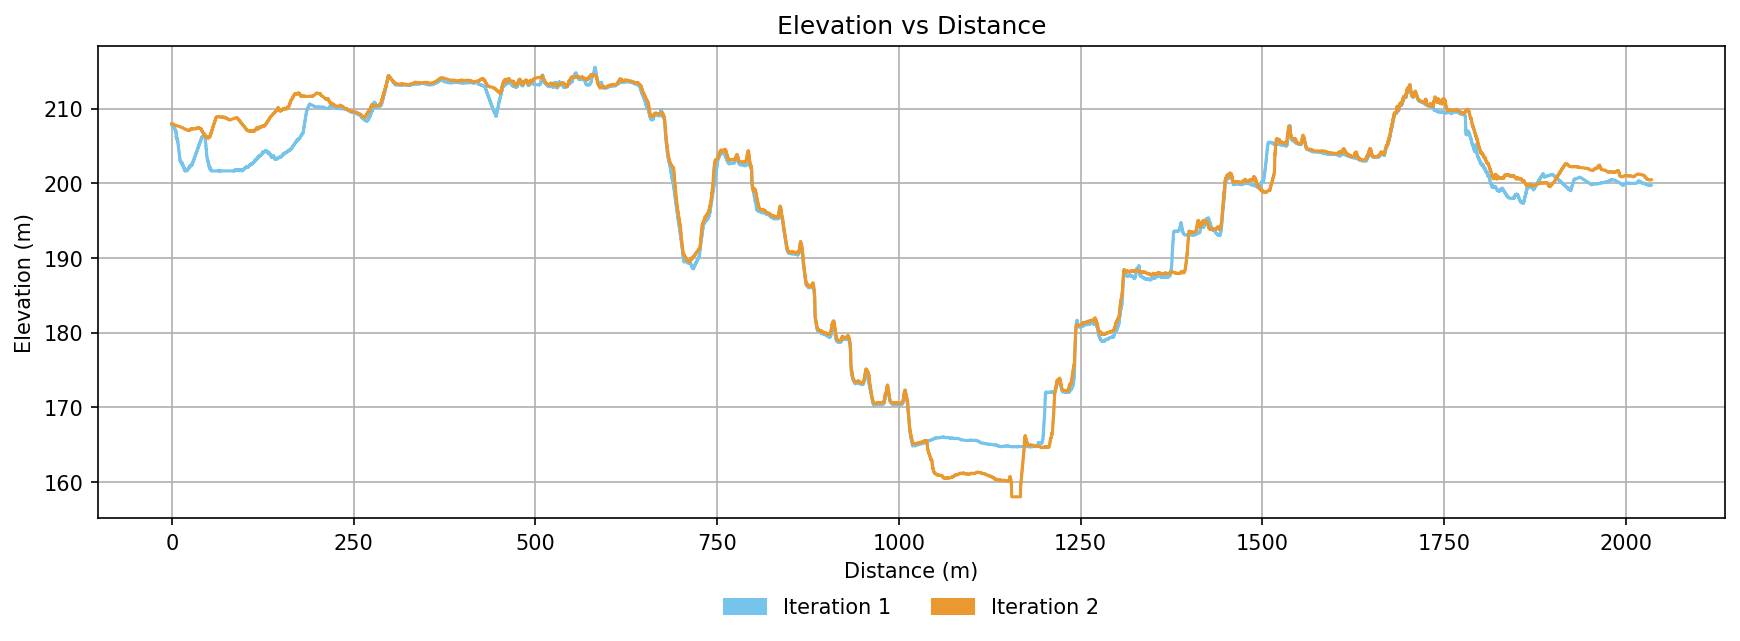

In [41]:
def plot_elevation_with_bottom_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs Distance",
    save_path: Optional[str] = None,
    show: bool = True
) -> Tuple[plt.Figure, plt.Axes]:
    
    # validate
    required = {"chainage", "z_itr1", "z_itr2"}
    if not required.issubset(section_df.columns):
        missing = required - set(section_df.columns)
        raise ValueError(f"section_df missing required columns: {missing}")

    # prepare data
    df = section_df.sort_values("chainage").reset_index(drop=True)
    if downsample is not None:
        if not (isinstance(downsample, int) and downsample > 0):
            raise ValueError("downsample must be a positive integer or None.")
        df_plot = df.iloc[::downsample].reset_index(drop=True)
    else:
        df_plot = df

    x = df_plot["chainage"].to_numpy()
    z1 = df_plot["z_itr1"].to_numpy()
    z2 = df_plot["z_itr2"].to_numpy()

    # colors
    color_itr1 = "#76c3ec"
    color_itr2 = "#e99930"

    # plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(x, z1, label="ITR-1", linewidth=1.5, color=color_itr1)
    ax.plot(x, z2, label="ITR-2", linewidth=1.5, color=color_itr2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

    # custom legend using colored boxes
    box1 = mpatches.Patch(color=color_itr1, label="Iteration 1")
    box2 = mpatches.Patch(color=color_itr2, label="Iteration 2")
    ax.legend(
        handles=[box1, box2],
        loc="lower center",
        bbox_to_anchor=(0.5, -0.25),
        ncol=2,
        frameon=False
    )

    # adjust layout so legend fits below
    plt.subplots_adjust(bottom=0.25)

    # save if requested
    # if save_path:
    #     fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    #     print(f"Saved elevation profile to: {save_path}")

    if show:
        plt.show()

    return fig, ax


fig, ax = plot_elevation_with_bottom_legend(
            df_4,
            downsample=None,
            figsize=(14, 5),
            save_path="elevation_profile_bottom_legend.png"
            )

In [42]:
## planned_and_done_excavation
## unplanned_and_done_excavation
## planned_and_done_dump
## unplanned_and_done_dump 

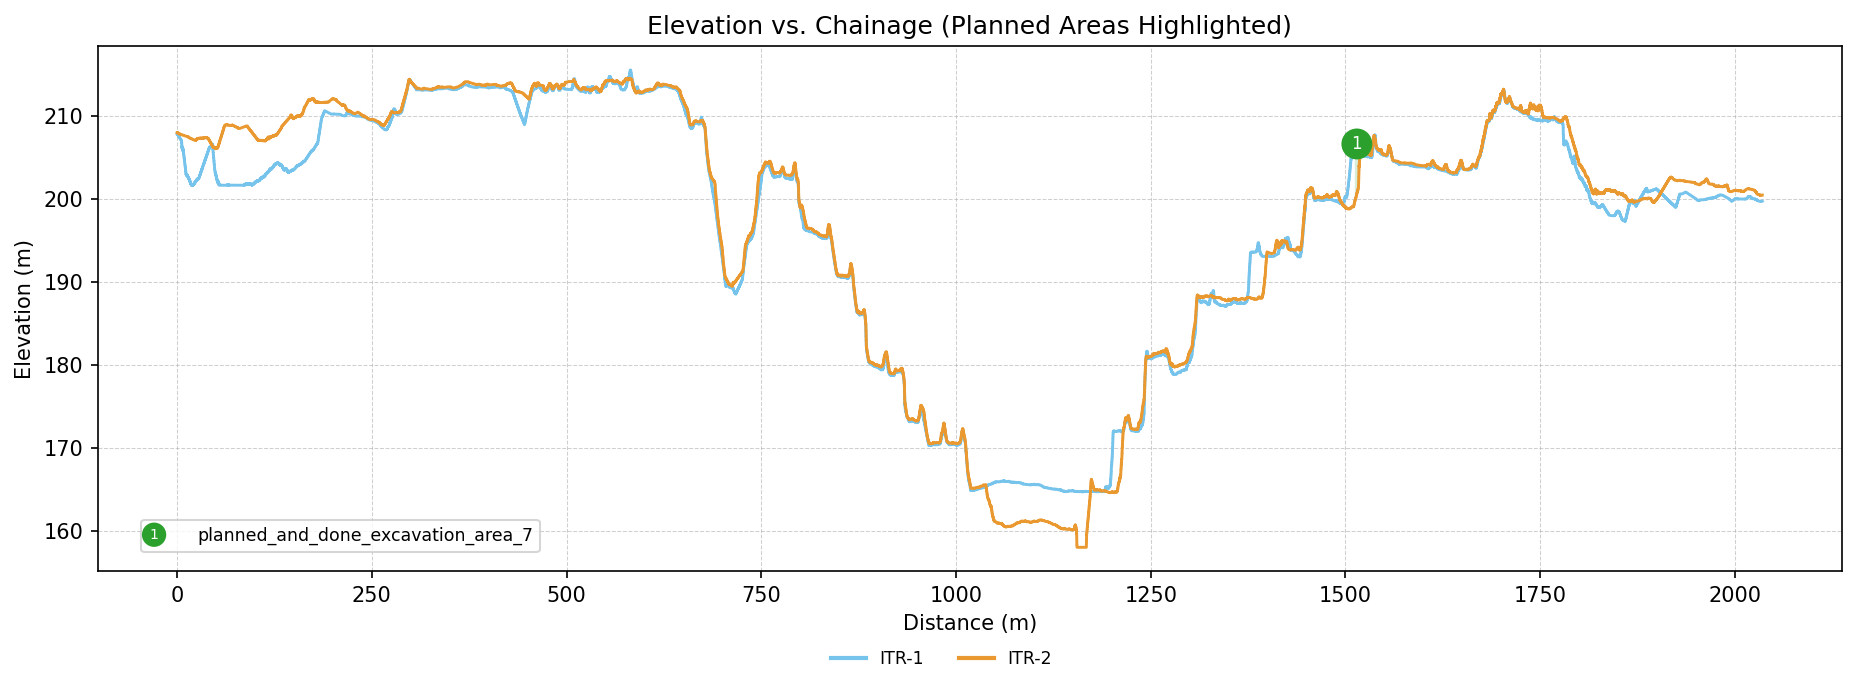

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # compute a circle size and position inside the legend box
        cx = xdescent + width / 6.0
        cy = ydescent + height / 2.0
        # radius relative to legend box height
        r = 1 * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        # draw number as Text object centered in the circle
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.8, ha="center", va="center")

        return [circle, num_text]


def plot_planned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned Areas Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",
    planned_alpha: float = 0.18
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    if downsample:
        df_plot = df_full.iloc[::downsample].reset_index(drop=True)
    else:
        df_plot = df_full

    # Base profile colors
    color_itr1, color_itr2 = "#76c3ec", "#e99930"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    n = len(df_full)
    i, num = 0, 1

    numbered_handles = []   # custom Circle handles (with _num attribute)
    numbered_labels = []    # labels like "1: Excavation area 23"

    # global z-range for offsetting markers above profile
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or lbl not in planned_set:
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        # Fill between ITR1 and ITR2 for this planned block
        ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])

        # midpoint and marker elevation
        mid_chain = (start_chain + end_chain) / 2.0
        elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range

        # draw circular marker (scatter) and centered white number
        ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
        ax.text(mid_chain, elev_marker, str(num), ha="center", va="center", fontsize=8, color="white", zorder=7)

        # create a small Circle patch to act as a legend handle and attach the number
        legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
        legend_circle._num = num  # used by our custom handler to draw the number
        numbered_handles.append(legend_circle)
        #numbered_labels.append(f"{num}: {current_area}")
        numbered_labels.append(current_area)

        num += 1

    # Figure-level legend for ITR-1 and ITR-2 only (placed below axes)
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # Internal (in-axes) legend for numbered areas (bottom-left inside axes)
    if numbered_handles:
        # pass handler_map mapping each specific handle instance to the numbered handler
        handler_map = {h: NumberedCircleHandler() for h in numbered_handles}
        ax.legend(handles=numbered_handles, labels=numbered_labels,
                  loc="lower left", bbox_to_anchor=(0.02, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map)
        # fig.legend already contains ITR lines; no need to re-add it

    plt.subplots_adjust(bottom=0.18)  # leave room for figure-level legend
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax

fig, ax = plot_planned_areas_with_numbered_legend(df_4)


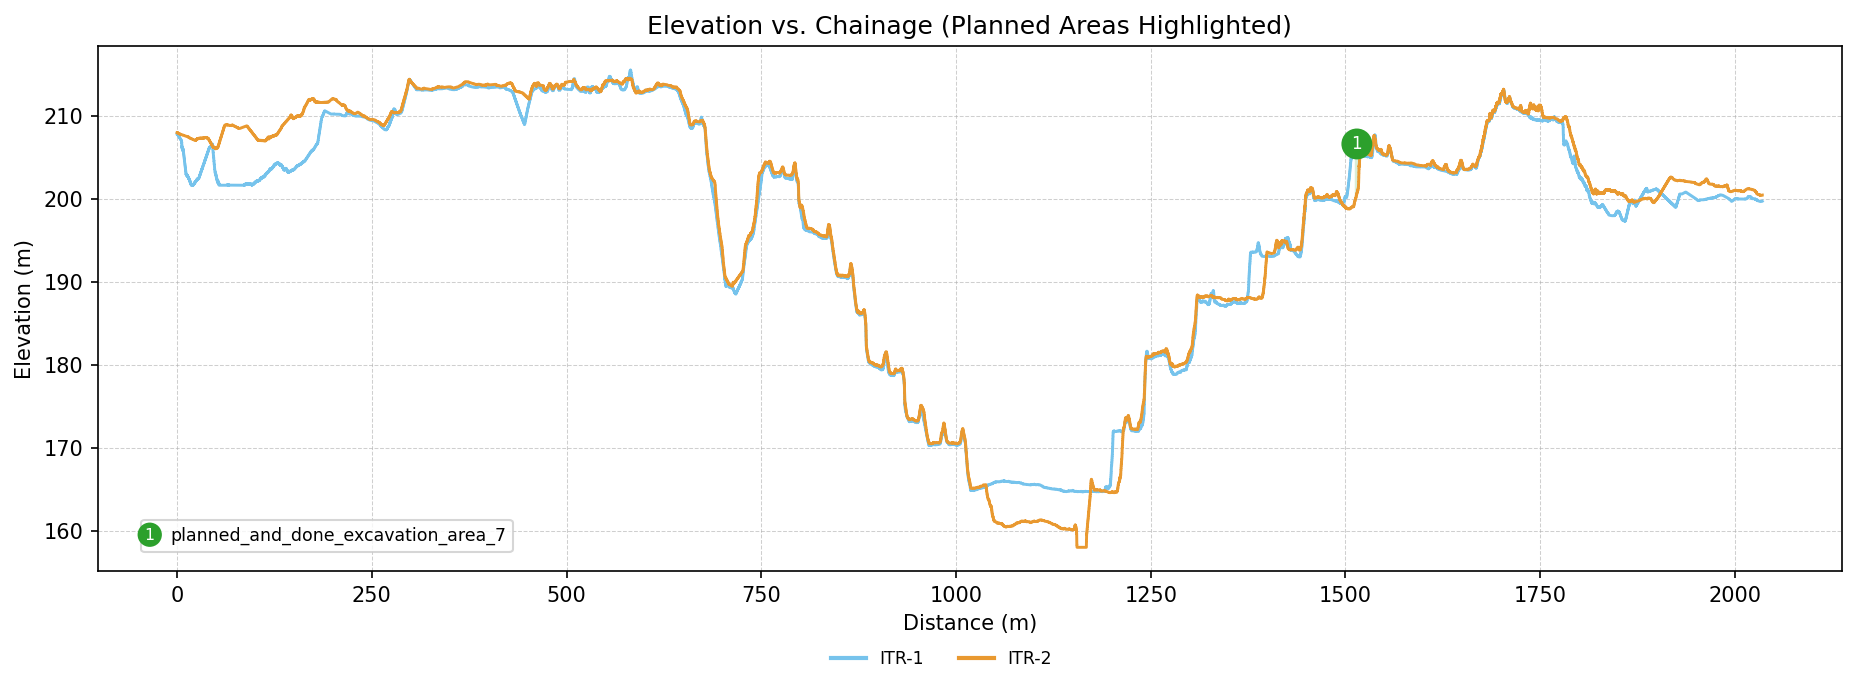

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    """
    Custom legend handler that draws a filled circle and a centered white number.
    The circle size is taken from orig_handle._size (fraction of legend box height).
    """

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # origin inside legend box
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0

        # size factor: default 0.45 if not provided on handle
        size_factor = getattr(orig_handle, "_size", 0.45)
        # radius relative to legend box height
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        # draw number as Text object centered in the circle
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")

        return [circle, num_text]


def plot_planned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned Areas Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",
    planned_alpha: float = 0.18,
    # new params to control legend spacing & legend circle size
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
    legend_circle_size: float = 0.55,   # fraction of legend box height
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    if downsample:
        df_plot = df_full.iloc[::downsample].reset_index(drop=True)
    else:
        df_plot = df_full

    # Base profile colors
    color_itr1, color_itr2 = "#76c3ec", "#e99930"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    n = len(df_full)
    i, num = 0, 1

    numbered_handles = []
    numbered_labels = []

    # global z-range for offsetting markers above profile
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or lbl not in planned_set:
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0
        elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range

        ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
        ax.text(mid_chain, elev_marker, str(num), ha="center", va="center", fontsize=8, color="white", zorder=7)

        # legend handle: set _num and _size attributes so handler can access them
        legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
        legend_circle._num = num
        legend_circle._size = legend_circle_size
        numbered_handles.append(legend_circle)

        # show only area name (no leading "1:")
        numbered_labels.append(current_area)

        num += 1

    # Figure-level legend for ITR-1 and ITR-2 only (placed below axes)
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # Internal (in-axes) legend for numbered areas (bottom-left inside axes)
    if numbered_handles:
        handler_map = {h: NumberedCircleHandler() for h in numbered_handles}
        ax.legend(handles=numbered_handles, labels=numbered_labels,
                  loc="lower left", bbox_to_anchor=(0.02, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)
        # fig.legend already contains ITR lines

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


fig, ax = plot_planned_areas_with_numbered_legend(
    df_4,
    legend_handletextpad=0.25,
    legend_labelspacing=0.5,
    legend_circle_size=1  # bigger circles in legend
)

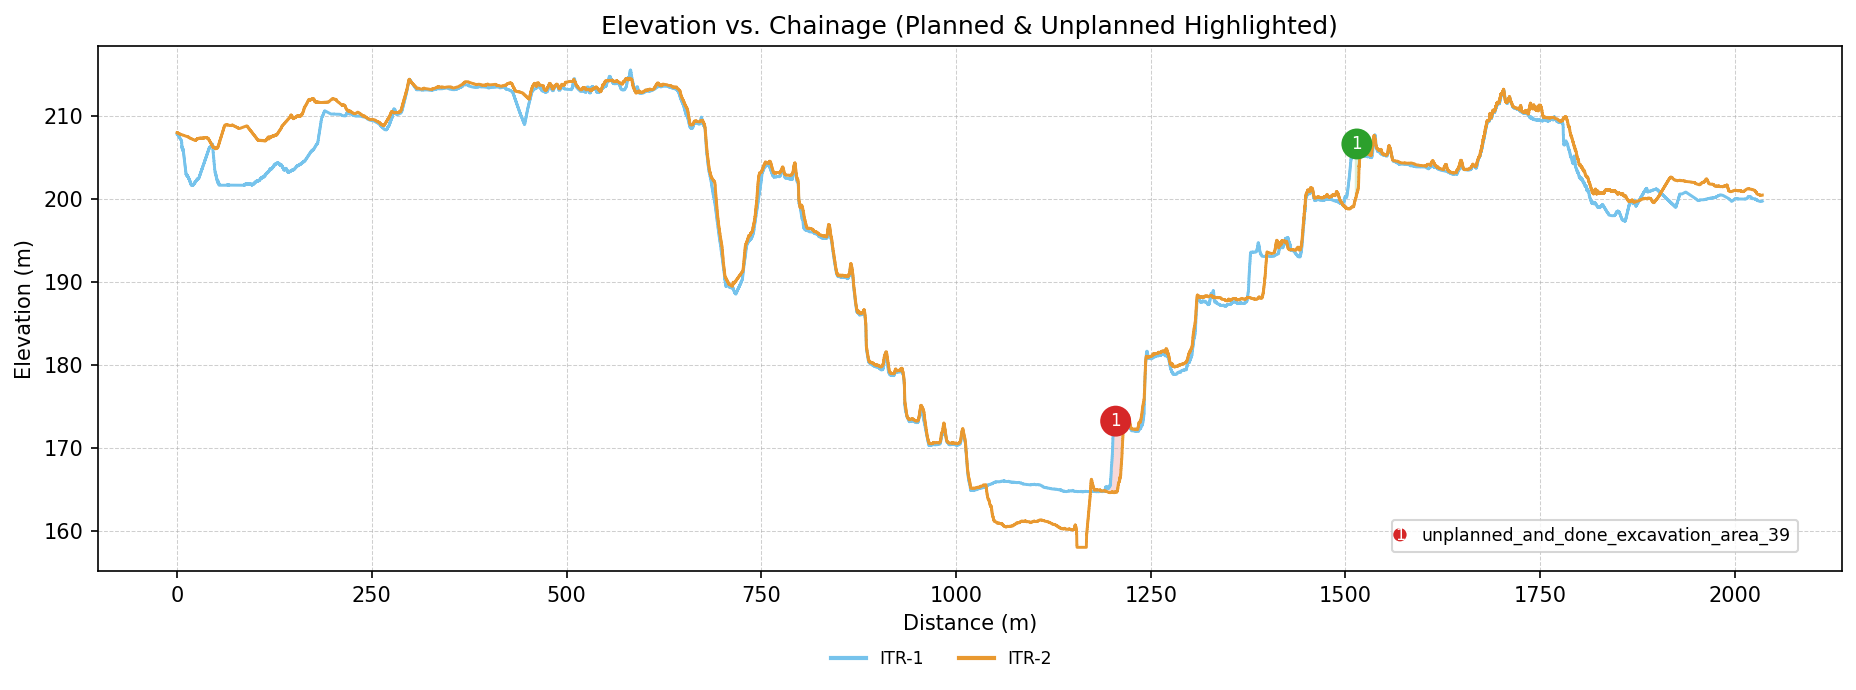

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.55,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

    # Categories
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0
        elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range

        # planned (green)
        if lbl in planned_set:
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)
            planned_labels.append(current_area)
            planned_num += 1

        # unplanned (red)
        elif lbl in unplanned_set:
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)
            unplanned_labels.append(current_area)
            unplanned_num += 1

    # External legend for ITR profiles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # Internal legend for planned (bottom-left)
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        ax.legend(handles=planned_handles, labels=planned_labels,
                  loc="lower left", bbox_to_anchor=(0.02, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Internal legend for unplanned (bottom-right)
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


fig, ax = plot_planned_and_unplanned_areas_with_numbered_legend(df_4)

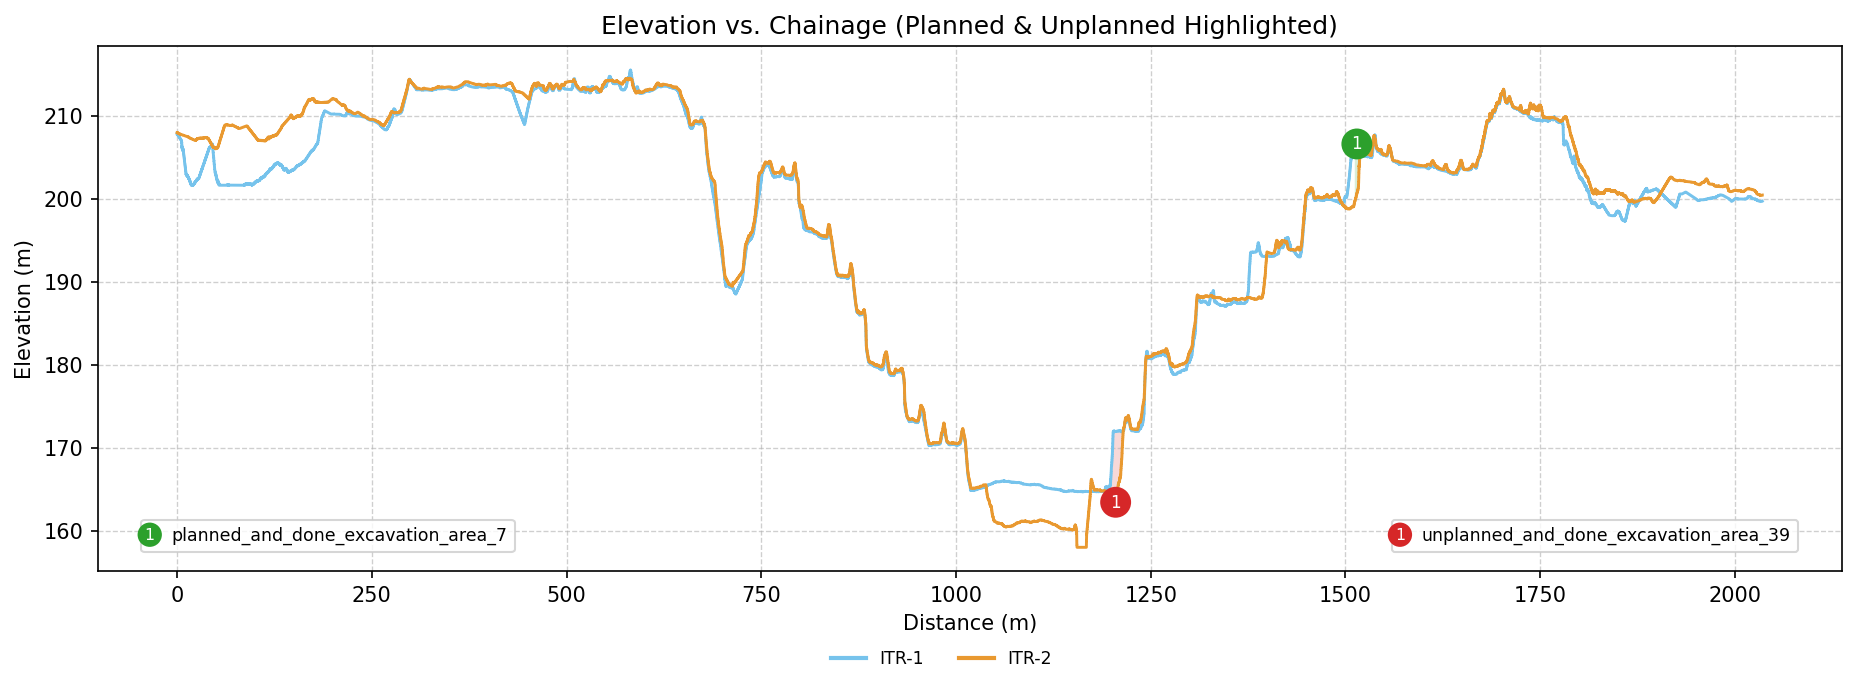

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,

    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 1,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)
            planned_labels.append(current_area)
            planned_num += 1

            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block
        elif lbl in unplanned_set:
            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)
            unplanned_labels.append(current_area)
            unplanned_num += 1

            marker_min = min(marker_min, elev_marker)

    # External legend for ITR profiles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


plot_planned_and_unplanned_areas_with_numbered_legend(df_4)

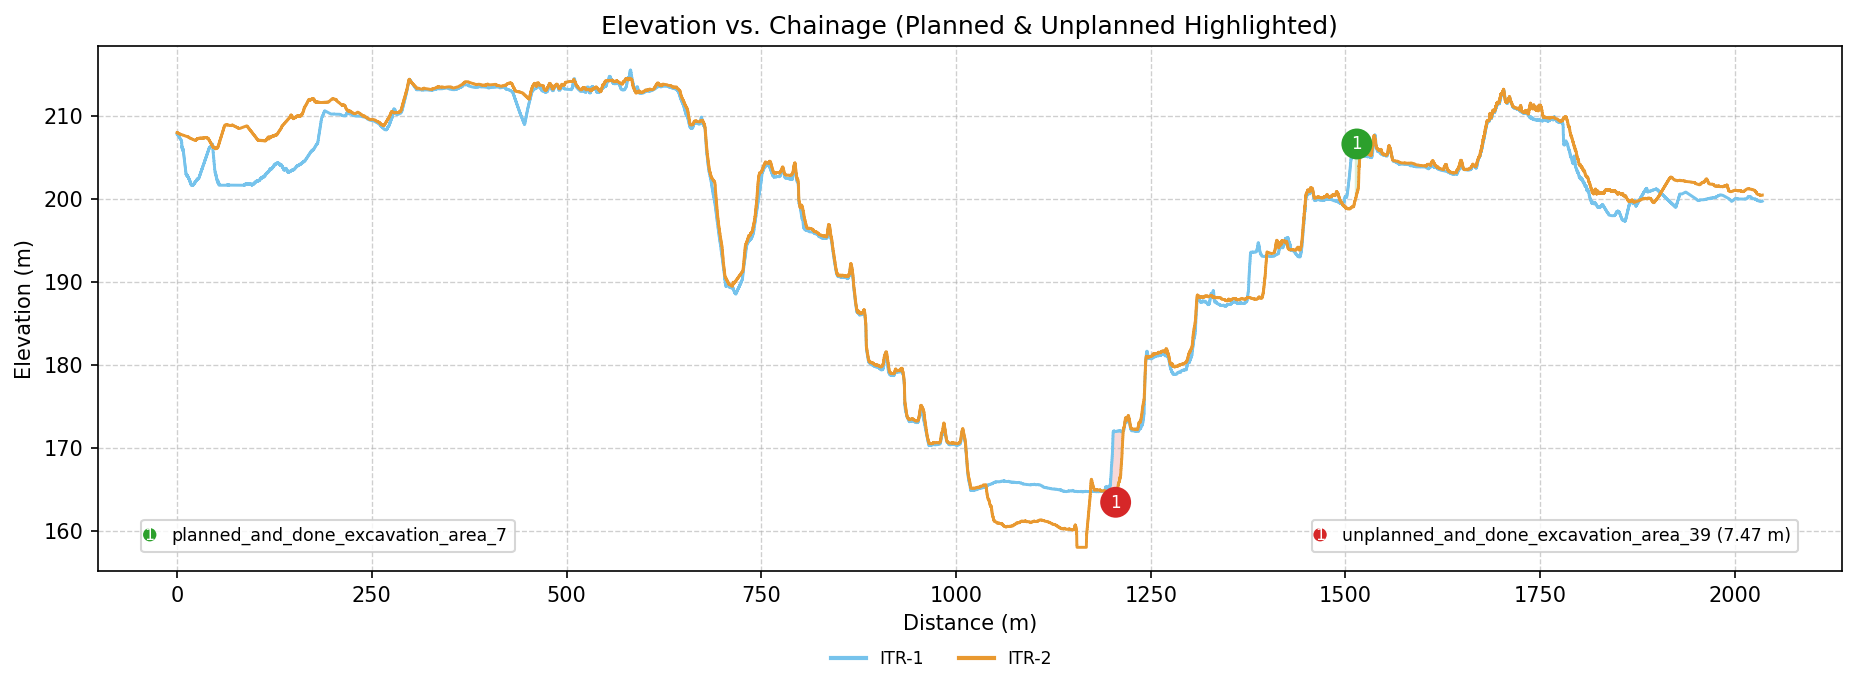

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': 'Elevation vs. Chainage (Planned & Unplanned Highlighted)'}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from typing import Optional, Tuple

class NumberedCircleHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        cx = xdescent + 0.5 * width / 6.0
        cy = ydescent + height / 2.0
        size_factor = getattr(orig_handle, "_size", 0.45)
        r = size_factor * height

        circle = mpatches.Circle((cx, cy), radius=r,
                                 transform=trans,
                                 facecolor=orig_handle.get_facecolor(),
                                 edgecolor='none', linewidth=0)
        num_text = plt.Text(cx, cy, str(getattr(orig_handle, "_num", "")),
                            transform=trans, color="white",
                            fontsize=fontsize * 0.9, ha="center", va="center")
        return [circle, num_text]


def plot_planned_and_unplanned_areas_with_numbered_legend(
    section_df: pd.DataFrame,
    *,
    figsize: Tuple[int, int] = (15, 5),
    dpi: int = 150,
    downsample: Optional[int] = None,
    xlabel: str = "Distance (m)",
    ylabel: str = "Elevation (m)",
    title: str = "Elevation vs. Chainage (Planned & Unplanned Highlighted)",
    save_path: Optional[str] = None,
    show: bool = True,
    planned_color: str = "#2ca02c",   # green
    unplanned_color: str = "#d62728", # red
    planned_alpha: float = 0.18,
    unplanned_alpha: float = 0.18,
    legend_circle_size: float = 0.55,
    legend_handletextpad: float = 0.35,
    legend_labelspacing: float = 0.4,
    legend_borderpad: float = 0.4,
    legend_handlelength: float = 1.0,
) -> Tuple[plt.Figure, plt.Axes]:

    req = {"chainage", "z_itr1", "z_itr2", "line_name", "area_name"}
    if not req.issubset(section_df.columns):
        raise ValueError(f"section_df missing required columns: {req - set(section_df.columns)}")

    df_full = section_df.sort_values("chainage").reset_index(drop=True)
    df_plot = df_full.iloc[::downsample].reset_index(drop=True) if downsample else df_full

    # Base profiles
    color_itr1, color_itr2 = "#76c3ec", "#e99930"
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(df_plot["chainage"], df_plot["z_itr1"], color=color_itr1, linewidth=1.4, label="ITR-1")
    ax.plot(df_plot["chainage"], df_plot["z_itr2"], color=color_itr2, linewidth=1.4, label="ITR-2")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", linewidth=0.65, alpha=0.6)

    # Categories (kept exact-match sets; adjust if your line_name varies)
    planned_set = {"planned_and_done_excavation", "planned_and_done_dump"}
    unplanned_set = {"unplanned_and_done_excavation", "unplanned_and_done_dump"}

    n = len(df_full)

    # Collect handles for legends
    planned_handles, planned_labels = [], []
    unplanned_handles, unplanned_labels = [], []

    # global z-range for offsetting markers
    zmax = df_full[["z_itr1", "z_itr2"]].max().max()
    zmin = df_full[["z_itr1", "z_itr2"]].min().min()
    z_range = zmax - zmin if zmax != zmin else 1.0

    i = 0
    planned_num, unplanned_num = 1, 1

    # track min/max marker to expand y-limits later if needed
    marker_min = float("inf")
    marker_max = float("-inf")

    while i < n:
        lbl = df_full.loc[i, "line_name"]
        if pd.isna(lbl) or (lbl not in planned_set and lbl not in unplanned_set):
            i += 1
            continue

        start_i = i
        current_area = df_full.loc[i, "area_name"]
        i += 1
        while i < n and df_full.loc[i, "line_name"] == lbl:
            i += 1
        end_i = i - 1

        x_block = df_full.loc[start_i:end_i, "chainage"].to_numpy()
        z1_block = df_full.loc[start_i:end_i, "z_itr1"].to_numpy()
        z2_block = df_full.loc[start_i:end_i, "z_itr2"].to_numpy()
        if x_block.size == 0:
            continue

        start_chain, end_chain = float(x_block[0]), float(x_block[-1])
        mid_chain = (start_chain + end_chain) / 2.0

        # planned (green) markers above block
        if lbl in planned_set:
            elev_marker = max(np.max(z1_block), np.max(z2_block)) + 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=planned_color, alpha=planned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=planned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(planned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=planned_color, edgecolor='none')
            legend_circle._num = planned_num
            legend_circle._size = legend_circle_size
            planned_handles.append(legend_circle)
            planned_labels.append(current_area)
            planned_num += 1

            marker_max = max(marker_max, elev_marker)

        # unplanned (red) markers below block — compute max deviation and add to label
        elif lbl in unplanned_set:
            # compute deviation: max absolute difference between z_itr1 and z_itr2 in the block
            deviation = float(np.max(np.abs(z1_block - z2_block)))

            elev_marker = min(np.min(z1_block), np.min(z2_block)) - 0.02 * z_range
            ax.fill_between(x_block, z1_block, z2_block, color=unplanned_color, alpha=unplanned_alpha, linewidth=0)
            ax.scatter([mid_chain], [elev_marker], s=220, color=unplanned_color, zorder=6, edgecolors='none')
            ax.text(mid_chain, elev_marker, str(unplanned_num), ha="center", va="center", fontsize=8, color="white", zorder=7)

            legend_circle = mpatches.Circle((0, 0), radius=0.5, facecolor=unplanned_color, edgecolor='none')
            legend_circle._num = unplanned_num
            legend_circle._size = legend_circle_size
            unplanned_handles.append(legend_circle)

            # attach deviation to the legend label (formatted to 2 decimals)
            unplanned_labels.append(f"{current_area} ({deviation:.2f} m)")

            unplanned_num += 1
            marker_min = min(marker_min, elev_marker)

    # External legend for ITR profiles
    itr1_handle = Line2D([0], [0], color=color_itr1, lw=2)
    itr2_handle = Line2D([0], [0], color=color_itr2, lw=2)
    fig.legend(handles=[itr1_handle, itr2_handle],
               labels=["ITR-1", "ITR-2"],
               loc="lower center", ncol=2, frameon=False, fontsize="small",
               bbox_to_anchor=(0.5, 0.03))

    # --- Create planned legend first and add it as an artist so it won't be replaced ---
    if planned_handles:
        handler_map = {h: NumberedCircleHandler() for h in planned_handles}
        leg_planned = ax.legend(handles=planned_handles, labels=planned_labels,
                                loc="lower left", bbox_to_anchor=(0.02, 0.02),
                                frameon=True, fontsize="small", handler_map=handler_map,
                                handletextpad=legend_handletextpad,
                                labelspacing=legend_labelspacing,
                                borderpad=legend_borderpad,
                                handlelength=legend_handlelength)
        ax.add_artist(leg_planned)

    # --- Then create unplanned legend (won't replace planned because we already added planned) ---
    if unplanned_handles:
        handler_map = {h: NumberedCircleHandler() for h in unplanned_handles}
        ax.legend(handles=unplanned_handles, labels=unplanned_labels,
                  loc="lower right", bbox_to_anchor=(0.98, 0.02),
                  frameon=True, fontsize="small", handler_map=handler_map,
                  handletextpad=legend_handletextpad,
                  labelspacing=legend_labelspacing,
                  borderpad=legend_borderpad,
                  handlelength=legend_handlelength)

    # Expand y-limits so no markers are clipped
    if marker_min != float("inf") or marker_max != float("-inf"):
        cur_ylim = ax.get_ylim()
        margin = 0.03 * z_range
        new_ymin = min(cur_ylim[0], marker_min - margin) if marker_min != float("inf") else cur_ylim[0]
        new_ymax = max(cur_ylim[1], marker_max + margin) if marker_max != float("-inf") else cur_ylim[1]
        ax.set_ylim(new_ymin, new_ymax)

    plt.subplots_adjust(bottom=0.18)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()

    return fig, ax


plot_planned_and_unplanned_areas_with_numbered_legend(df_4)